In [23]:
#import rpy2.robjects as robjects
#import rpy2.robjects.packages as rpackages
#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter
from anndata import AnnData
import scanpy as sc
from os import path
import os
#from rpy2.robjects.packages import importr
#base = importr('base')
import numpy as np
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from tqdm.auto import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import random
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as putil
from sklearn.metrics import root_mean_squared_error, mean_poisson_deviance
import torch
from torch import optim, distributions, nn
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf

In [24]:
random.seed(256)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
root_path = "/engelhardt/home/pshrestha/vnngp/"
SPATH = path.join(root_path, 'results/merfish')
nsf_path = path.join(SPATH, 'nsf')
nnnsf_path = path.join(SPATH, 'nnnsf')
dpth = path.join(root_path, "data/")
merpath = path.join(dpth, "merfish.h5ad")

In [26]:
ad = sc.read_h5ad(merpath)
min_value = np.min(ad.X)
print(min_value)
if min_value < 0:
    ad.X += np.abs(min_value)

-8.701701306928275


In [27]:
ad.var_names_make_unique()

In [28]:
#ad.var["mt"] = ad.var_names.str.startswith("mt-")
#sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
#ad = ad[ad.obs.pct_counts_mt < 20]
#sc.pp.filter_genes(ad, min_cells=1)
#sc.pp.filter_cells(ad, min_counts=100)
#ad.layers = {"counts":ad.X.copy()}

In [29]:
ad.X.shape

(21458, 3000)

In [30]:
labels = ad.obs.Age.unique()

In [31]:
labels

array([29.  ,  4.7 , 20.8 ,  6.7 ,  3.33, 14.5 , 18.58,  5.4 , 20.6 ,
        9.47, 22.57, 16.53,  3.3 ,  8.4 , 12.47, 21.57,  4.3 , 10.43,
       22.6 ,  3.6 , 23.9 , 16.83, 18.87, 24.9 , 25.93, 14.77])

In [32]:
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')

In [33]:
ad

AnnData object with n_obs × n_vars = 21458 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'nCount_LMO', 'nFeature_LMO', 'LMO_maxID', 'LMO_secondID', 'LMO_margin', 'LMO_classification', 'LMO_classification.global', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'Celltype', 'Celltype.LowRes', 'Age', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.5', 'SCT_snn_res.0.2', 'SCT_snn_res.0.1', 'SCT_snn_res.0.15', 'SCT_snn_res.0.18', 'SCT_snn_res.0.19', 'SCT_snn_res.0.17', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Prolif_Lineage_Fraction_of_SVZ', 'Age_cat'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'X_umap_har'
    varm: 'HARMONY', 'PCs'

In [34]:
ad = ad[~ad.obs['Age'].isin([20.8, 22.6, 3.33])]

In [35]:
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

In [36]:
ad.uns['counts'] = ad.X.copy()

/tmp/ipykernel_801848/466964688.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ad.uns['counts'] = ad.X.copy()


In [37]:
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]

In [38]:
ad

View of AnnData object with n_obs × n_vars = 19252 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'nCount_LMO', 'nFeature_LMO', 'LMO_maxID', 'LMO_secondID', 'LMO_margin', 'LMO_classification', 'LMO_classification.global', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'Celltype', 'Celltype.LowRes', 'Age', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.5', 'SCT_snn_res.0.2', 'SCT_snn_res.0.1', 'SCT_snn_res.0.15', 'SCT_snn_res.0.18', 'SCT_snn_res.0.19', 'SCT_snn_res.0.17', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Prolif_Lineage_Fraction_of_SVZ', 'Age_cat'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable', 'deviance_poisson'
    uns: 'counts'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'X_umap_har'
    varm: 'HARMONY', 'PCs'

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: 

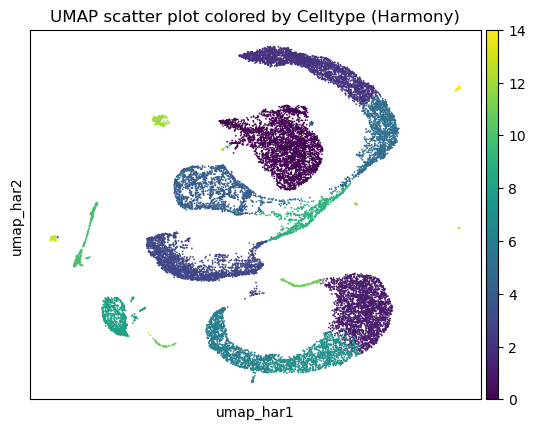

In [39]:
sc.pl.embedding(ad, basis='umap_har', color='Celltype', title='UMAP scatter plot colored by Celltype (Harmony)')

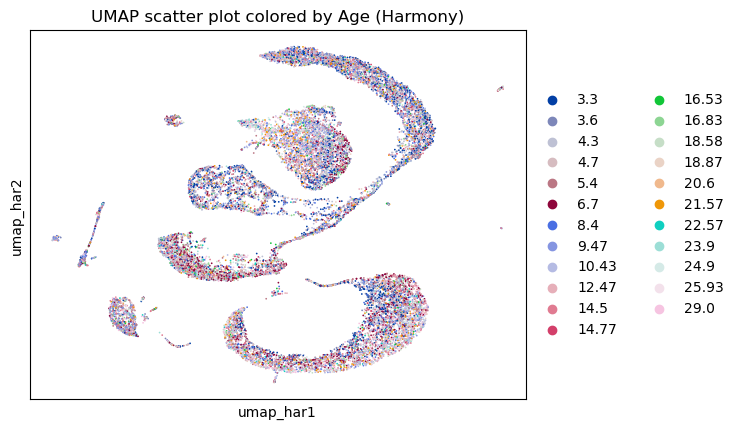

In [40]:
sc.pl.embedding(ad, basis='umap_har', color='Age_cat', title='UMAP scatter plot colored by Age (Harmony)')

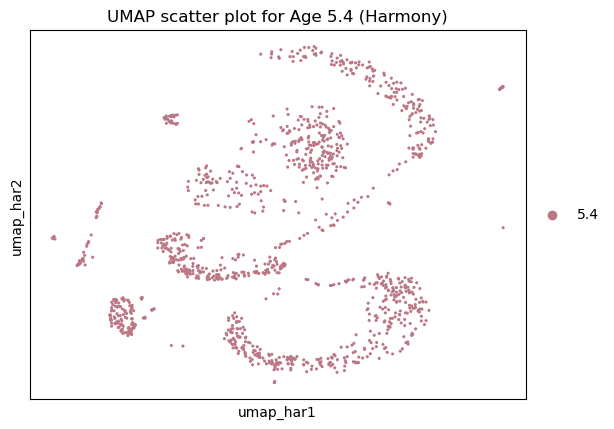

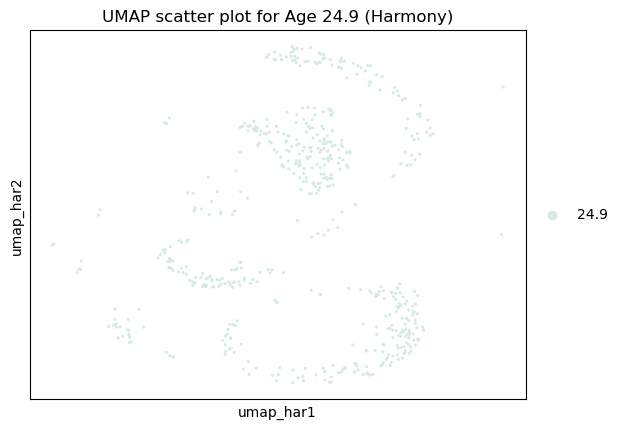

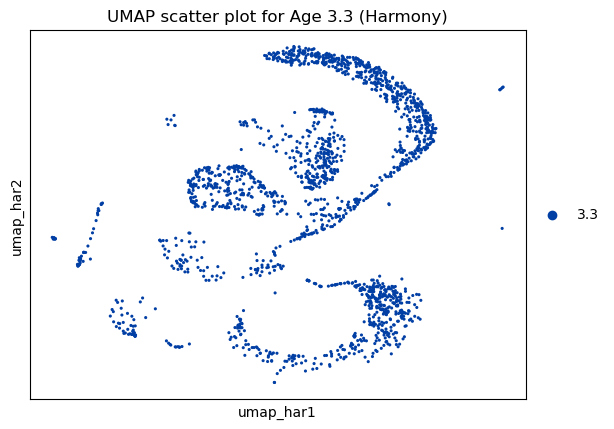

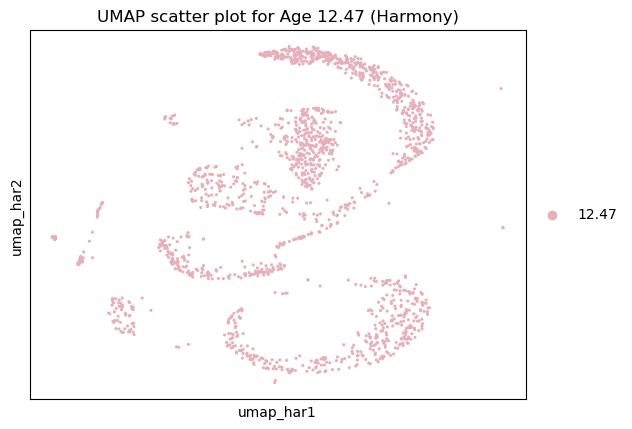

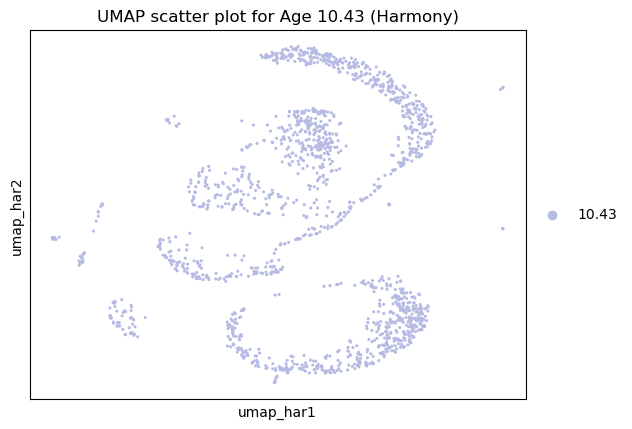

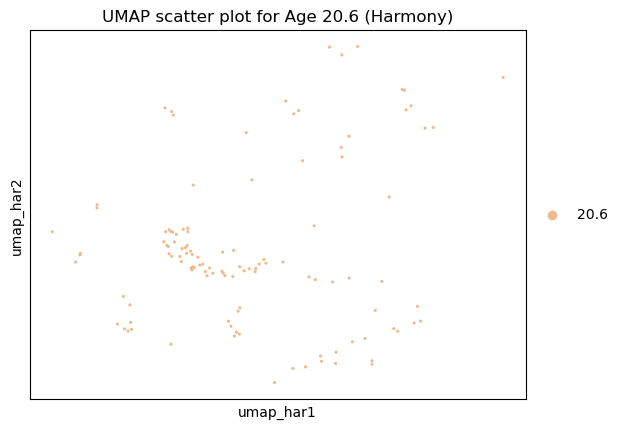

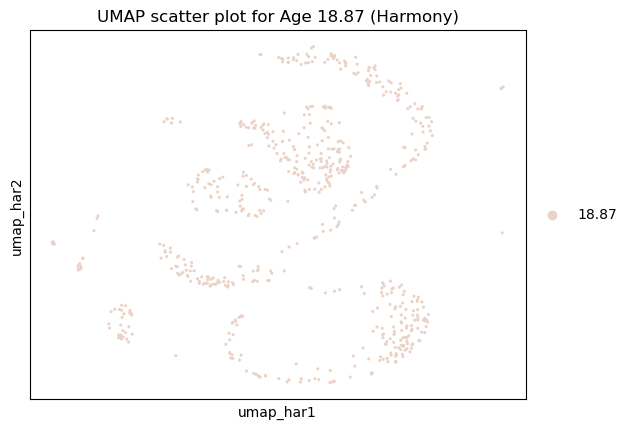

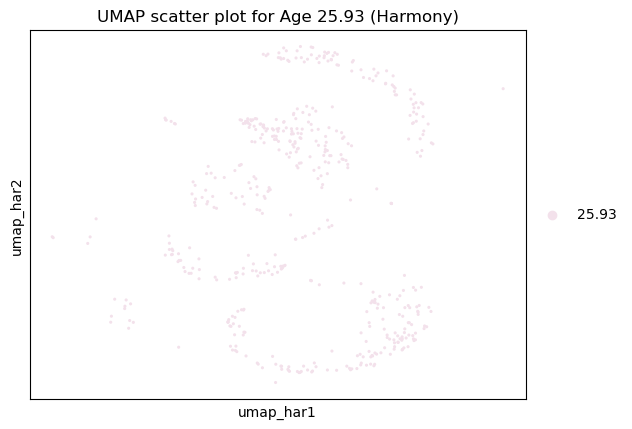

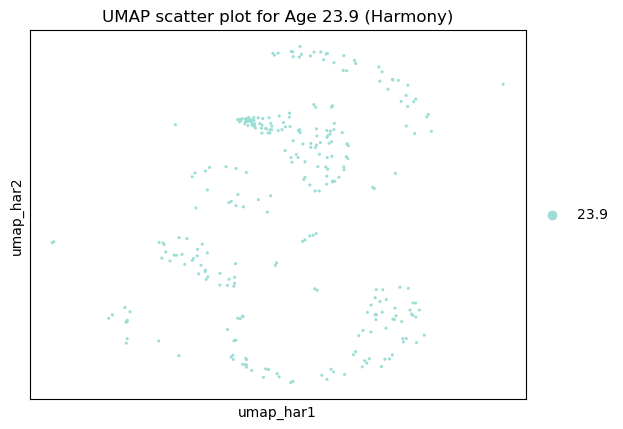

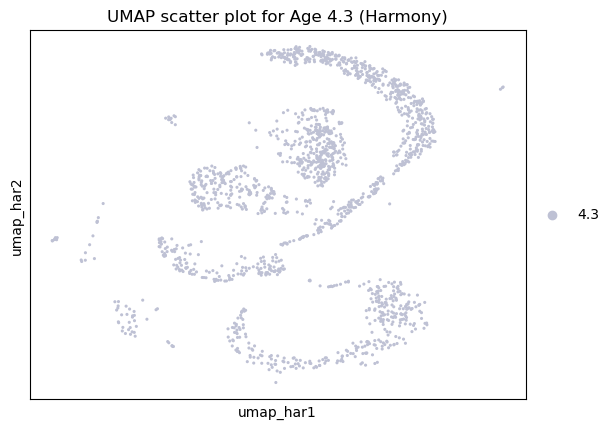

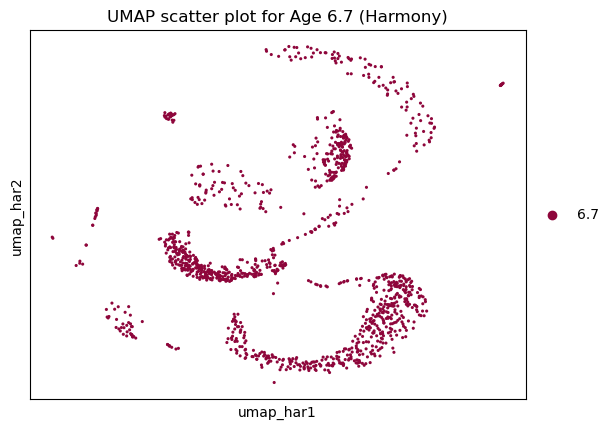

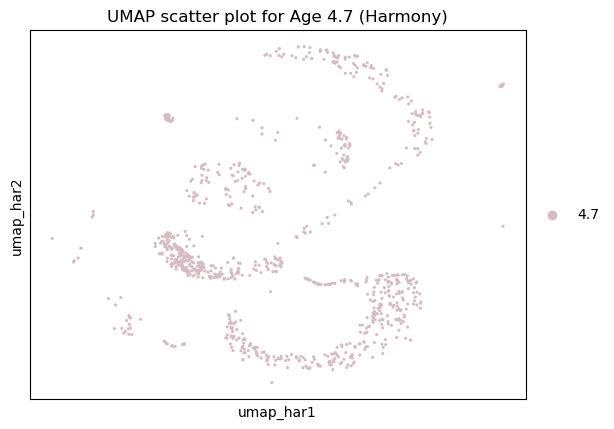

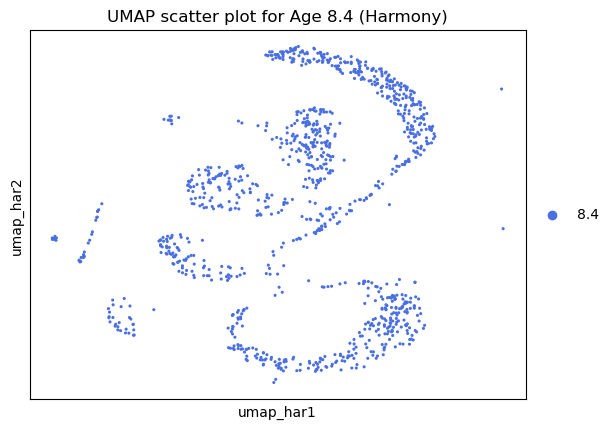

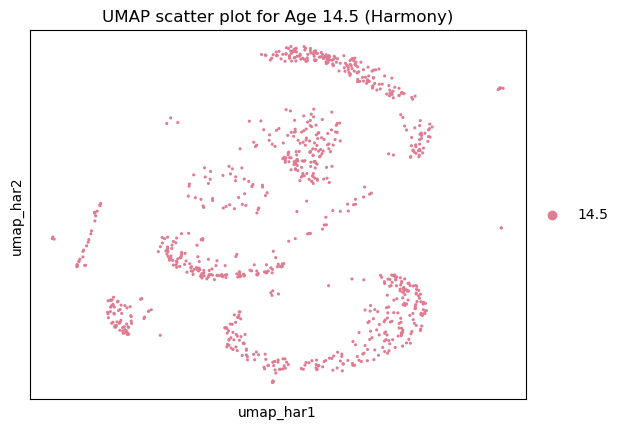

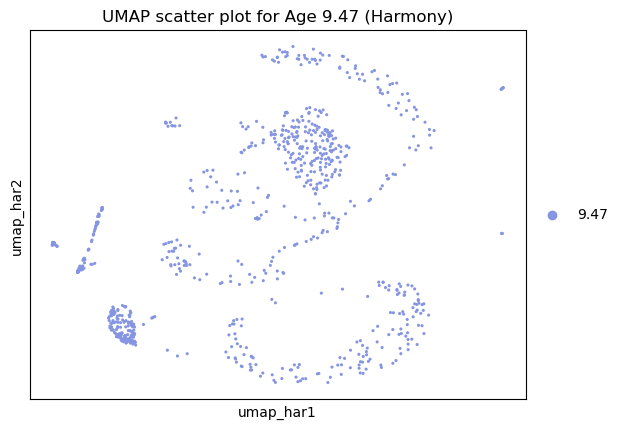

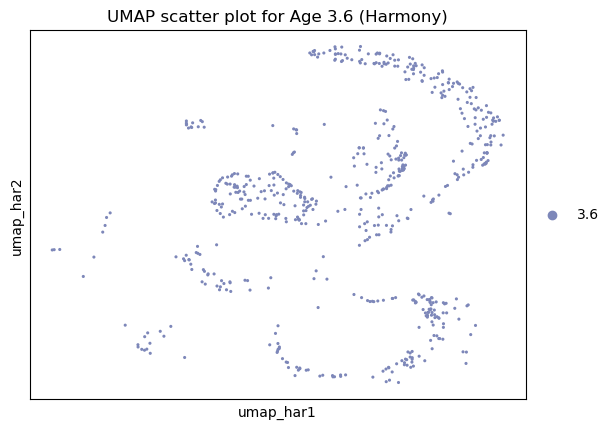

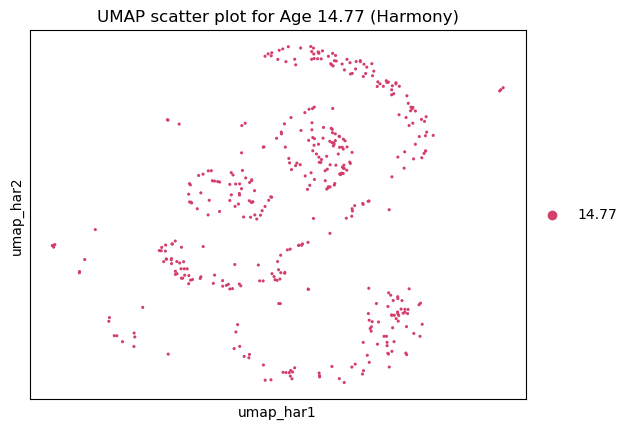

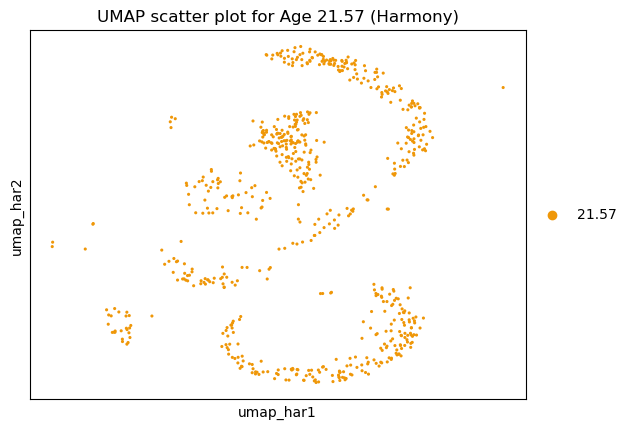

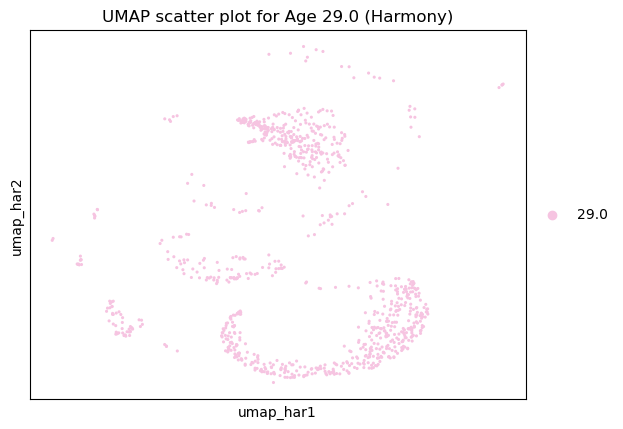

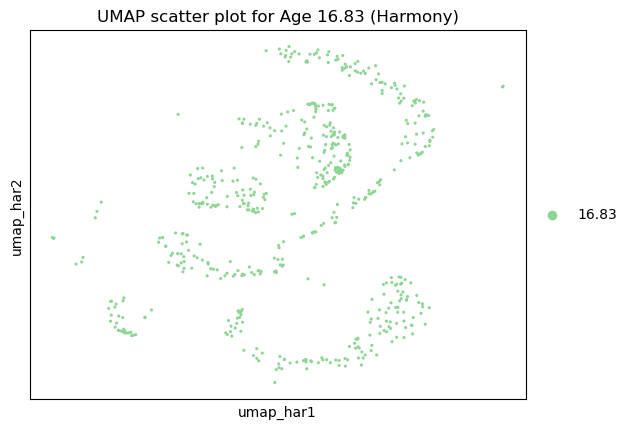

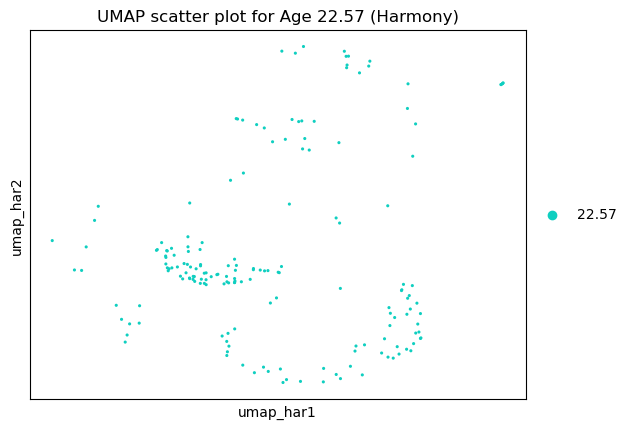

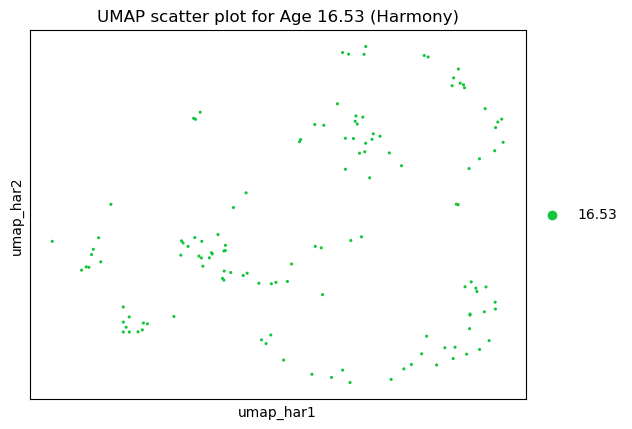

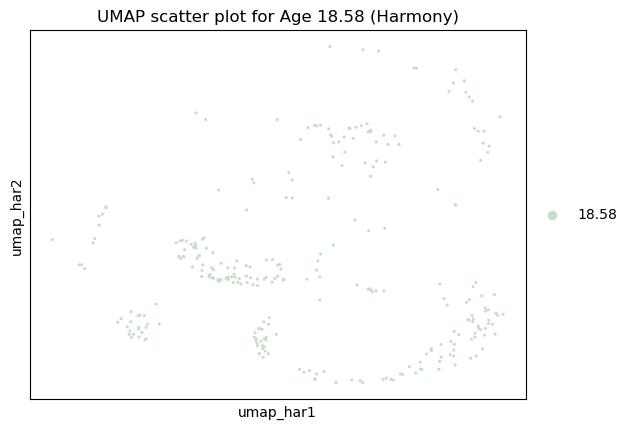

In [41]:
unique_ages = ad.obs['Age_cat'].unique()

for age in unique_ages:
    # Filter the data for the current age category
    ad_age_filtered = ad[ad.obs['Age_cat'] == age]
    
    # Plot UMAP for the current age category
    sc.pl.embedding(ad_age_filtered, 
                    basis='umap_har', 
                    color='Age_cat', 
                    title=f'UMAP scatter plot for Age {age} (Harmony)', 
                    cmap='rocket', size=20)

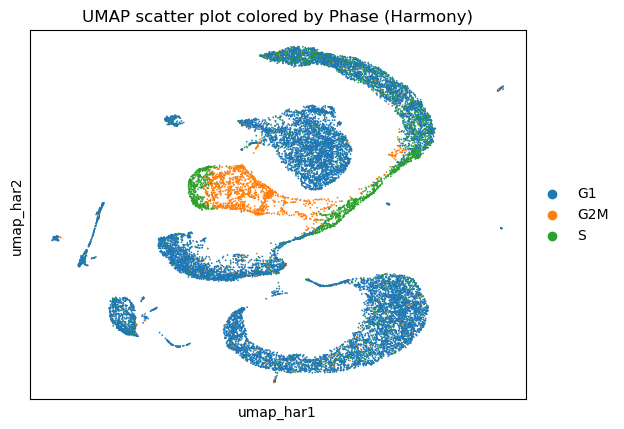

In [42]:
sc.pl.embedding(ad, basis='umap_har', color='Phase', title='UMAP scatter plot colored by Phase (Harmony)')

/tmp/ipykernel_801848/91688182.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(index='Age', columns='Phase', aggfunc='size', fill_value=0)


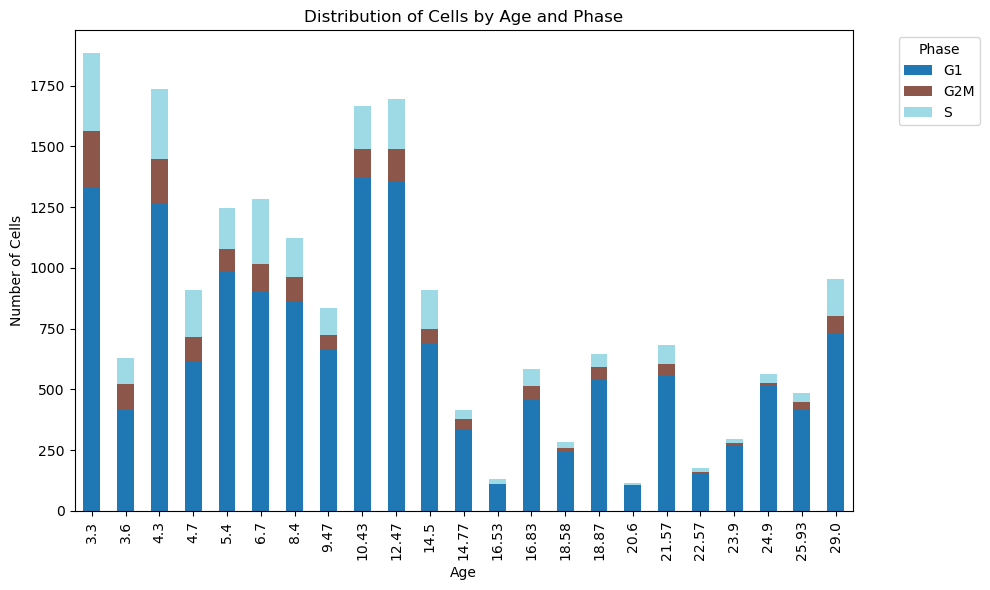

In [43]:
# Extract the relevant columns from the AnnData object
df = ad.obs[['Age', 'Phase']]

# Create a pivot table to get counts of each Celltype per Age
pivot_df = df.pivot_table(index='Age', columns='Phase', aggfunc='size', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cells by Age and Phase')
plt.xticks(rotation=90)
plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

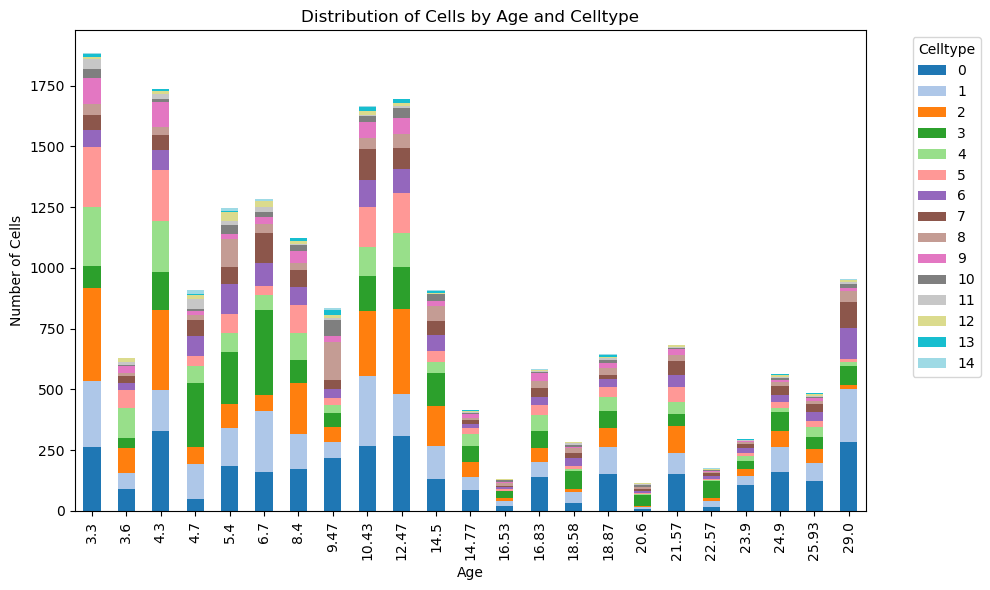

In [44]:
# Extract the relevant columns from the AnnData object
df = ad.obs[['Age', 'Celltype']]

# Create a pivot table to get counts of each Celltype per Age
pivot_df = df.pivot_table(index='Age', columns='Celltype', aggfunc='size', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cells by Age and Celltype')
plt.xticks(rotation=90)
plt.legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

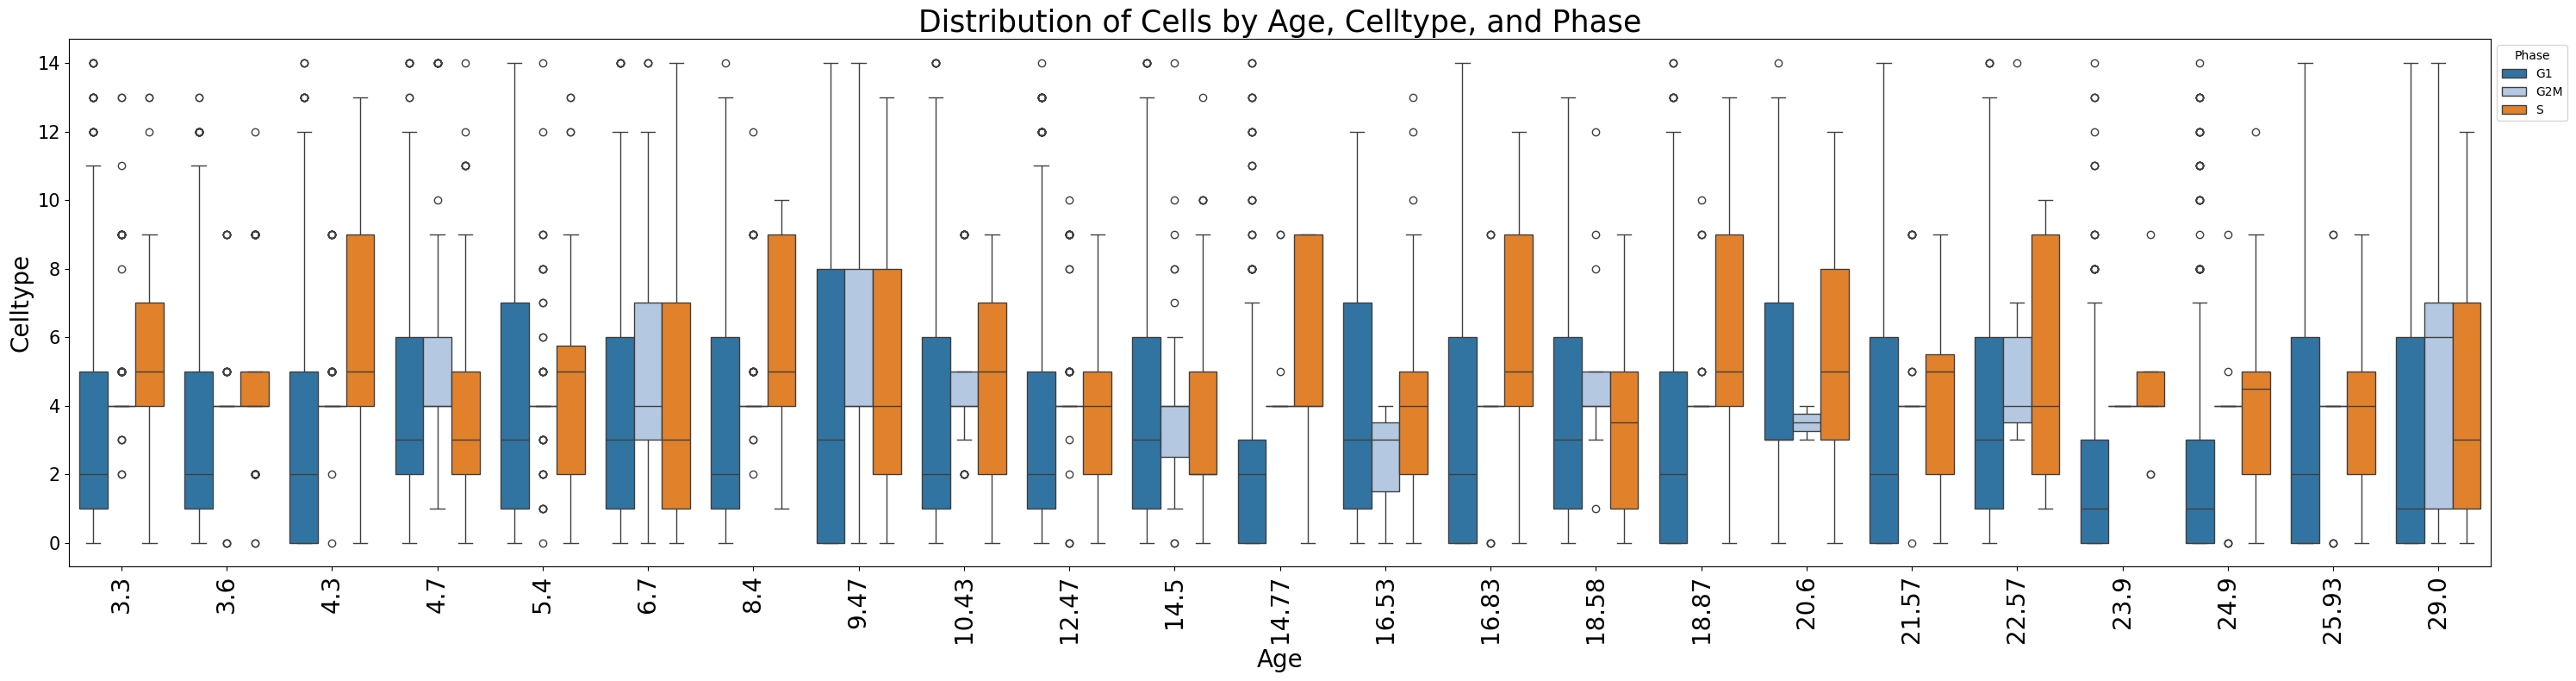

In [45]:
# Extract the relevant columns from the AnnData object
df = ad.obs[['Age', 'Celltype', 'Phase']]

# Set up the plot
plt.figure(figsize=(30, 8))
sns.boxplot(x='Age', y='Celltype', hue='Phase', data=df, palette='tab20')
plt.xlabel('Age', size=20)
plt.ylabel('Celltype', size=20)
plt.title('Distribution of Cells by Age, Celltype, and Phase', size=25)
plt.xticks(rotation=90, size=20)
plt.yticks(size=15)
plt.legend(title='Phase', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

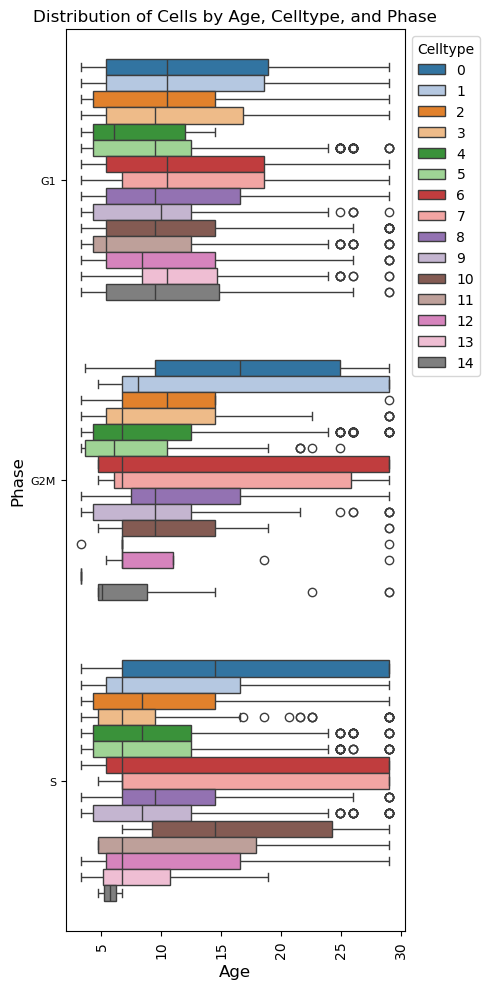

In [46]:
# Set up the plot
plt.figure(figsize=(5, 10))
sns.boxplot(x='Age', y='Phase', hue='Celltype', data=df, palette='tab20')
plt.xlabel('Age', size=12)
plt.ylabel('Phase', size=12)
plt.title('Distribution of Cells by Age, Celltype, and Phase', size=12)
plt.xticks(rotation=90, size=10)
plt.yticks(size=8)
plt.legend(title='Celltype', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

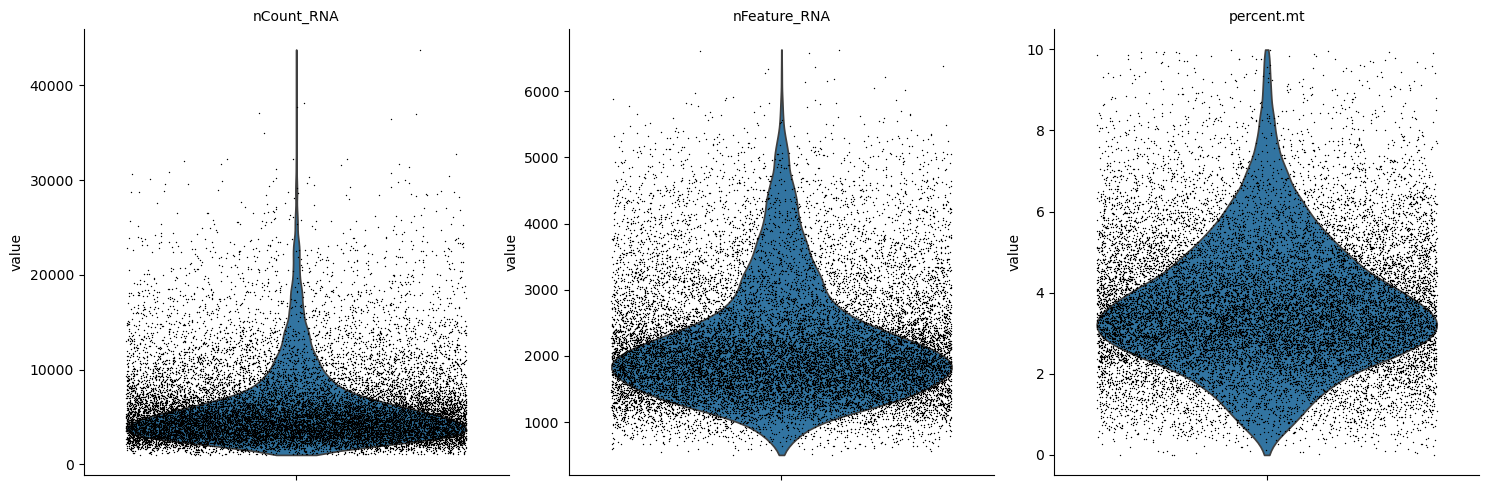

In [47]:
qc_metrics = ['nCount_RNA', 'nFeature_RNA', 'percent.mt']
sc.pl.violin(ad, qc_metrics, jitter=0.4, multi_panel=True)

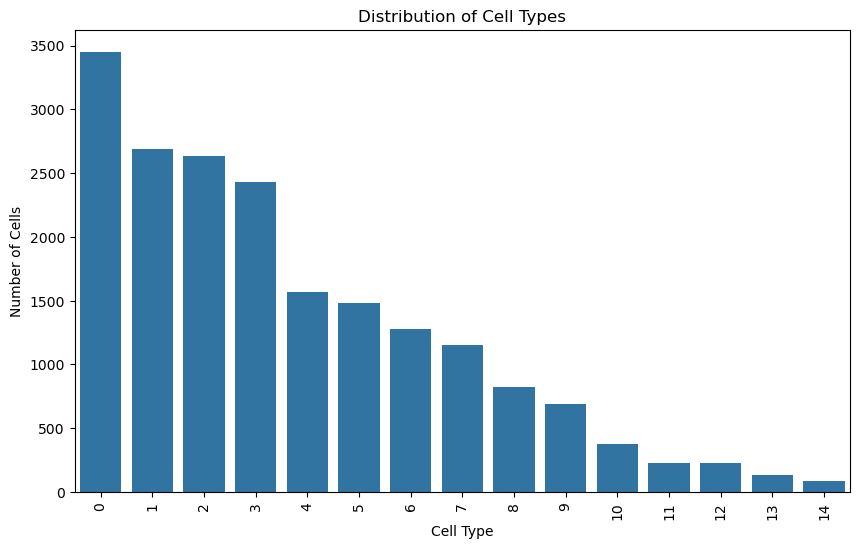

In [48]:
# Bar plot for cell type distribution
celltype_counts = ad.obs['Celltype'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=celltype_counts.index, y=celltype_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cell Types')
plt.show()

In [49]:
# Shift the matrix by adding a constant to make all values non-negative

In [50]:
#Y = np.array(ad.X)
#X = np.array(ad.obs['Age'])[:, None]

In [51]:
# (Num Observations, Num Genes)
print(X.shape)
print(Y.shape)

(19252, 50)
(3000, 19252)


In [52]:
Y.mean()

8.199975448438257

In [53]:
len(ad.obs['Age_cat'].unique())

23

### NMF Initialization

In [132]:
l=12
nmf_model = NMF(n_components=l, max_iter=100, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [133]:
nmf_model.fit(Y.T)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=100, n_components=12,
    random_state=0)

In [134]:
W = nmf_model.fit_transform(Y.T)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [135]:
factors = np.log(np.exp(W) + 1e-2)
loadings = nmf_model.components_.T#*5

In [136]:
def dims_autocorr_timeseries(factors, sort=True, lags=10):
    """
    factors: (num observations) x (num latent dimensions) array
    sort: if True (default), returns the index and autocorrelation statistics in decreasing
    order of autocorrelation. If False, returns the index and autocorrelation statistics
    according to the ordering of factors.

    returns: an integer array of length (num latent dims), "idx"
    and a numpy array containing the ACF values for each dimension

    indexing factors[:,idx] will sort the factors in decreasing order of temporal
    autocorrelation.
    """
    num_factors = factors.shape[1]
    acf_values = np.zeros(num_factors)

    # Compute ACF for each latent dimension (factor)
    for i in range(num_factors):
        factor_series = factors[:, i]
        
        # Compute the autocorrelation function (ACF) for the current factor
        acf_result = acf(factor_series, nlags=lags)
        
        # Store the sum of autocorrelation values (can change this to any ACF-based metric)
        acf_values[i] = np.sum(np.abs(acf_result))

    # Get the sorted indices based on ACF values
    if sort:
        idx = np.argsort(-acf_values)  # Sort in descending order
    else:
        idx = np.arange(num_factors)  # Keep original order

    return idx, acf_values[idx]

In [137]:
acf_idx, acf_val = dims_autocorr_timeseries(factors)

In [138]:
factors = factors[:, acf_idx]
loadings = loadings[:, acf_idx]

In [139]:
print(factors.shape)
print(loadings.shape)

(19252, 12)
(3000, 12)


In [140]:
save_path = '/engelhardt/home/pshrestha/vnngp/results/merfish'

In [141]:
# save nmf models
nmf_path = path.join(save_path, 'nmf')
np.save(path.join(nmf_path, f'nmf_factors_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33).npy'), factors)
np.save(path.join(nmf_path, f'nmf_loadings_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33).npy'), loadings)

In [142]:
#ad.obsm['X_nmf'] = W

### UMAPS

In [54]:
def plot_umap_factors(loadings, ad):
    L = loadings.shape[1]
    size = 2
    fig, axes = plt.subplots(L // 6, 6, figsize=(size * 6, size * (L // 6)), tight_layout=True)

    # Find the global vmin and vmax across all factors
    #vmin = loadings.min().min()
    #vmax = loadings.max().max()

    for i in range(L):
        curr_ax = axes[i // 6, i % 6]
        sc.pl.embedding(
            ad,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=curr_ax,
            show=False,
            cmap='magma', 
        )

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_umap_factors_by_age(loadings, adata, dot_size=10):  # Added dot_size parameter
    L = loadings.shape[1]
    size = 2
    unique_ages = sorted(adata.obs['Age'].unique())  # Sort ages from youngest to oldest
    print(unique_ages)
    num_ages = len(unique_ages)
    vmin = loadings.min().min()
    vmax = loadings.max().max()

    
    # Create subplots
    fig, axes = plt.subplots(L, num_ages + 1, figsize=(size * (num_ages + 1), size * L), tight_layout=True)
    
    for i in range(L):
        # Plot the original UMAP for the factor
        sc.pl.embedding(adata, basis='umap_har', color=f'Factor {i+1}', ax=axes[i, 0], show=False, cmap='magma', size=dot_size, vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f'Factor {i+1} - Original')
        
        # Plot UMAPs for each age
        for j, age in enumerate(unique_ages):
            adata_age = adata[adata.obs['Age'] == age]
            sc.pl.embedding(
            adata_age,
            basis='umap_har',
            color=f'Factor {i+1}',
            ax=axes[i, j + 1],
            show=False,
            cmap='viridis',
            vmin=vmin,
            vmax=vmax,  # Set the global color limits
            size=dot_size
            )
            axes[i, j + 1].set_title(f'Age {age}')
    
    plt.tight_layout()
    plt.show()
    return fig

## Factors

In [55]:
ad = sc.read_h5ad(merpath)
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)
ad.var_names_make_unique()
labels = ad.obs.Age.unique()
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')
ad = ad[~ad.obs['Age'].isin([20.8, 22.6, 3.33])]
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.X, dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float32')
Y = Y.astype('float32')
X = rescale_spatial_coords(X)
ad.uns['counts'] = ad.X.copy()
    
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
    
X = np.array(ad.obs['Age'])[:, None]
X = torch.tensor(X, dtype=torch.float)
    
Y = np.log(np.exp(Y) + 1e-2)  # correction
#Y = Y.T

/tmp/ipykernel_801848/1764869500.py:15: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ad.uns['counts'] = ad.X.copy()


In [ ]:
params = {
        'L': 18, 
        'M': 1000, 
        'K': 8,
        'sigma': 0.3, 
        'lengthscale': 0.02, 
        'jtr': 0.01,
        'batch_size': 128,
        'lr': 0.01,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}

nmf_save_path = path.join(SPATH, 'nmf')
factors_path = path.join(nmf_save_path, f"3000/nmf_factors_iter=1000_rs=256_L={params['L']}_rm(20.8, 22.6, 3.33).npy")
loadings_path = path.join(nmf_save_path, f"3000/nmf_loadings_iter=1000_rs=256_L={params['L']}_rm(20.8, 22.6, 3.33).npy")
factors = np.load(factors_path)
loadings = np.load(loadings_path)
acf_idx, acf_val = putil.dims_autocorr_timeseries(factors)
factors = factors[:, acf_idx]
loadings = loadings[:, acf_idx]

NNNSF = putil.build_model(np.array(X), np.array(Y), loadings=np.array(loadings), factors=np.array(factors), model_type='VNNGP', kwargs=params)

X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

nnnsf_path = path.join(SPATH,'nnnsf') 
file_path = f"3000_d1_no_spatial_standardization_0/VNNGP_K={params['K']}_lkzz=1_M={params['M']}_L={params['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_state_dict.pth"
modelname = f"3000_d1_no_spatial_standardization_0/VNNGP_K={params['K']}_lkzz=1_M={params['M']}_L={params['L']}_lr=0.01_jtr=0.1_ls=0.02_sigma=0.3_bs=128_NMFinit_model.pt"
dict_path = path.join(nnnsf_path, file_path)
model_path = path.join(nnnsf_path, modelname)
NNNSF.load_state_dict(torch.load(dict_path))
nnnsf_model_dict = torch.load(model_path)

NNNSF.cpu()
qF, _, _ = NNNSF.prior(X.cpu(), kwargs=params)
mean = torch.exp(qF.mean).detach().numpy()
W = (NNNSF.W).cpu()
W_transformed = nn.functional.softplus(W.T)
W_transformed = W_transformed.detach().numpy()
y_nnnsf = ((mean.T)).dot(W_transformed)

In [ ]:
ad.obsm['X_nnnsf'] = mean.T
sc.pp.neighbors(ad, use_rep='X_nnnsf')
sc.tl.umap(ad)

for i in range((mean.T).shape[1]):
    ad.obs[f'Factor {i+1}'] = (mean.T)[:, i]

In [ ]:
fig, ax = plot_umap_factors(loadings, ad)  
#fig.suptitle(f'Factors | sigma: {params["sigma"]}, lengthscale: {params["lengthscale"]}')
#fig.savefig(f"{SPATH}/nnnsf_l={params['L']}_plot.png")

In [ ]:
#plot_umap_factors_by_age(loadings, ad)

In [ ]:
# Create a DataFrame for loadings and assign gene names as index
loadings_df = pd.DataFrame(W_transformed.T, index=ad.var_names)

# Get the top 10 genes for each factor
top_genes = {}

for factor in range(loadings_df.shape[1]):
    # Sort genes by loadings in descending order for this factor
    sorted_genes = loadings_df.iloc[:, factor].sort_values(ascending=False)
    
    # Get the top 10 genes
    top_genes[f'Factor_{factor+1}'] = sorted_genes.head(10).index.tolist()

# Convert the result into a DataFrame to visualize
top_genes_df = pd.DataFrame(top_genes)
print(top_genes_df)

In [ ]:
top_genes_indices = {}

# Loop through each factor in top_genes_df
for factor in top_genes_df.columns:
    # Get the gene names for the factor
    genes = top_genes_df[factor]
    
    # Find the corresponding indices of these genes in ad.var_names
    indices = [list(ad.var_names).index(gene) for gene in genes]
    
    # Store the indices in the dictionary
    top_genes_indices[factor] = indices

# Convert the dictionary to a DataFrame for easier viewing
top_genes_indices_df = pd.DataFrame(top_genes_indices)
print(top_genes_indices_df)

In [ ]:
L = loadings.shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(12, 1, figsize=(size*10, size*20), tight_layout=False)

# Loop over each factor
for i in range(L):
    # Get the top 10 genes' indices for Factor i+1
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    
    # Get the actual gene names for these indices
    gene_names = ad.var_names[top_genes].to_list()
    
    # Subset the data matrix to the top 10 genes for Factor i+1
    gene_data = ad[:, top_genes].X  # Assuming ad.X holds gene expression
    
    # Create a DataFrame to combine the top 10 genes and relevant metadata
    df = pd.DataFrame(gene_data, columns=gene_names)  # Use actual gene names as column labels
    df['Age'] = ad.obs['Age'].values
    df['Celltype'] = ad.obs['Celltype'].values
    df['Phase'] = ad.obs['Phase'].values
    
    curr_ax = axes[i % 12]
    
    # Melt the DataFrame to convert it into a long format
    df_melted = pd.melt(df, id_vars=['Age', 'Celltype', 'Phase'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')
    
    # Plot the scatter plot, coloring by the gene (hue=Gene) and labeling the legend with gene names
    sns.scatterplot(x='Age', y='Expression', hue='Gene', data=df_melted, palette='Set2', ax=curr_ax)
    
    curr_ax.set_title(f"Factor {i+1} - Top 10 Genes", size=15)

plt.tight_layout()
plt.show()

In [ ]:
L = (W_transformed.T).shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(18, 1, figsize=(size*4, size*18), tight_layout=False)

sns.set_style("whitegrid")
# Loop over each factor
for i in range(L):
    print(f"Plotting factor {i}")
    # Get the top 10 genes' indices for Factor i+1
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    
    # Get the actual gene names for these indices
    gene_names = ad.var_names[top_genes].to_list()
    
    # Subset the data matrix to the top 10 genes for Factor i+1
    gene_data = ad[:, top_genes].X  # Assuming ad.X holds gene expression
    
    # Create a DataFrame to combine the top 10 genes and relevant metadata
    df = pd.DataFrame(gene_data, columns=gene_names)  # Use actual gene names as column labels
    df['Age'] = ad.obs['Age'].values
    df['Celltype'] = ad.obs['Celltype'].values
    df['Phase'] = ad.obs['Phase'].values
    
    # Aggregate the data by Age and Gene, taking the mean expression for each gene at each age
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()

    curr_ax = axes[i % 18]
    
    # Melt the aggregated DataFrame to convert it into a long format
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')
    
    # Plot the line plot, coloring by the gene (hue=Gene) and labeling the legend with gene names
    sns.lineplot(x='Age', y='Expression', hue='Gene', data=df_melted, palette='Set2', ax=curr_ax, linewidth=2, legend=False)
    sns.scatterplot(x='Age', y='Expression', hue='Gene', data=df_melted, palette='Set2', ax=curr_ax, legend=True)

    # Get the unique age values
    unique_ages = df_aggregated['Age'].unique()
    
    # Select first, middle, and last ages for the x-tick labels
    middle_age = unique_ages[len(unique_ages) // 2]
    tick_ages = [unique_ages[0], middle_age, unique_ages[-1]]
    
    # Set the x-ticks to all unique ages for grid lines
    curr_ax.set_xticks(unique_ages)  # This ensures grid lines appear for all ages
    
    # Create a list of labels with only first, middle, and last ages labeled, others blank
    #tick_labels = ['' for _ in unique_ages]
    #tick_labels[0] = unique_ages[0]  # First age
    #tick_labels[len(unique_ages) // 2] = middle_age  # Middle age
    #tick_labels[-1] = unique_ages[-1]  # Last age
    
    # Set the x-tick labels
    curr_ax.set_xticklabels(unique_ages, rotation=90, fontsize=8)
    
    # Set the title for the current axis
    curr_ax.set_title(f"Factor {i+1}", size=11)
    
    # Despine the current axis
    sns.despine(ax=curr_ax)
    
    # Move legend outside the plot and remove the legend box
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)
    #curr_ax.set_aspect('equal')

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig(f'{save_path}/{file_path}_median_expression_nnnsf.png')
plt.show()

In [ ]:
from scipy.interpolate import interp1d

L = (W_transformed.T).shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(18, 1, figsize=(size*4, size*18), tight_layout=False)

sns.set_style("whitegrid")

for i in range(L):
    print(f"Plotting factor {i}")
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    gene_names = ad.var_names[top_genes].to_list()
    gene_data = ad[:, top_genes].X

    df = pd.DataFrame(gene_data, columns=gene_names)
    df['Age'] = ad.obs['Age'].values
    
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()
    curr_ax = axes[i % 18]
    
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')

    # Interpolate to create smoother lines
    for gene in gene_names:
        subset = df_melted[df_melted['Gene'] == gene]
        x = subset['Age']
        y = subset['Expression']
        f = interp1d(x, y, kind='linear')
        
        # Generate more points to make a smoother curve
        x_new = np.linspace(x.min(), x.max(), 100)
        y_smooth = f(x_new)
        
        curr_ax.plot(x_new, y_smooth, label=gene, linewidth=2)
        #curr_ax.scatter(x, y)
        curr_ax.set_xlabel("Ages")
        curr_ax.set_ylabel("Medial Expression")

    unique_ages = df_aggregated['Age'].unique()
    middle_age = unique_ages[len(unique_ages) // 2]
    tick_ages = [unique_ages[0], middle_age, unique_ages[-1]]
    
    curr_ax.set_xticks(unique_ages)
    #tick_labels = ['' for _ in unique_ages]
    #tick_labels[0] = unique_ages[0]
    #tick_labels[len(unique_ages) // 2] = middle_age
    #tick_labels[-1] = unique_ages[-1]
    
    curr_ax.set_xticklabels(unique_ages, rotation=90, fontsize=8)
    curr_ax.set_title(f"Factor {i+1}", size=11)
    sns.despine(ax=curr_ax)
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)

plt.subplots_adjust(hspace=0.7)  # Adjust spacing between plots
plt.savefig(f'{SPATH}/median_expression_nnnsf_rm.png')
plt.show()

In [ ]:
from scipy.interpolate import interp1d

# Dictionary mapping each factor to a list of genes to exclude
genes_to_exclude_by_factor = {
    0: ['Gm34084', 'Slamf8', 'Adora2a', 'Slpi', 'Lamc3', 'Lcn2'], 
    1: ['Fezf2', 'Fam20a', 'Tgfb1i1'],  
    2: ['Ppp1r17', 'Rasd1', 'H2-Q4', 'Cfap53', 'Gpnmb', 'Hhip'],
    3: ['Scn1a', 'Cdhr4', 'Kcna5', 'Spaca9', 'Tek', 'Dlk1', 'Gpr62', 'Atp2a3'],
    4: ['Ogn', 'Cox8b', 'Cdk6', 'Ank', 'll1r1', 'Rgs22', 'Plk2'],
    7: ['Syne2', 'Krtap28-13', 'Tek', 'Selplg', 'CT025619.1', 'Gbp4', 'Tmem252', 'Gm12002'],
    9: ['C1s1', 'Ogn', 'Cdk6', 'Cpox', 'Ttc9b', 'Ndrg1', 'Mki76'],
    15: ['Itgam', 'Smim22', 'Gm48427', 'Cdc20', 'Gm5150','C3ar1', 'Racgap1']
    
}

L = (W_transformed.T).shape[1]  # Number of factors
size = 2
fig, axes = plt.subplots(18, 1, figsize=(size*4, size*18), tight_layout=False)

sns.set_style("white")

for i in range(L):
    #print(f"Plotting factor {i+1}")
    top_genes = top_genes_indices_df[f'Factor_{i+1}']
    gene_names = ad.var_names[top_genes].to_list()
    
    # Remove specific genes for the current factor if specified in the dictionary
    genes_to_exclude = genes_to_exclude_by_factor.get(i, [])
    gene_names = [gene for gene in gene_names if gene not in genes_to_exclude]
    
    # Subset the data matrix to the filtered top genes for Factor i+1
    gene_data = ad[:, [ad.var_names.get_loc(g) for g in gene_names]].X

    # Create a DataFrame to combine the top genes and relevant metadata
    df = pd.DataFrame(gene_data, columns=gene_names)
    df['Age'] = ad.obs['Age'].values
    
    df_aggregated = df.groupby('Age')[gene_names].median().reset_index()
    curr_ax = axes[i % 18]
    
    df_melted = pd.melt(df_aggregated, id_vars=['Age'], value_vars=gene_names, 
                        var_name='Gene', value_name='Expression')

    # Interpolate to create smoother lines
    for gene in gene_names:
        subset = df_melted[df_melted['Gene'] == gene]
        x = subset['Age']
        y = subset['Expression']
        f = interp1d(x, y, kind='quadratic') # next
        
        # Generate more points to make a smoother curve
        x_new = np.linspace(x.min(), x.max(), 100)
        y_smooth = f(x_new)
        
        # Plot the smoothed curve and scatter points
        curr_ax.plot(x_new, y_smooth, label=gene, linewidth=1.5)
        #curr_ax.scatter(x, y, s=5)
        curr_ax.set_xlabel("Ages")
        curr_ax.set_ylabel("Median Expression")

    unique_ages = df_aggregated['Age'].unique()
    middle_age = unique_ages[len(unique_ages) // 2]
    tick_ages = [unique_ages[0], middle_age, unique_ages[-1]]
    
    curr_ax.set_xticks(unique_ages)
    curr_ax.set_xticklabels(unique_ages, rotation=90, fontsize=8)
    curr_ax.set_title(f"Factor {i+1}", size=11)
    sns.despine(ax=curr_ax)
    curr_ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=8)

plt.subplots_adjust(hspace=0.7)  # Adjust spacing between plots
plt.show()

In [ ]:
import warnings
from sklearn.metrics import explained_variance_score
from scipy.stats import norm, pearsonr, spearmanr  # Assuming Gaussian log-likelihood
from scipy.special import gammaln
from scipy.spatial.distance import jensenshannon

def explained_variance(y_true, y_pred):
    return explained_variance_score(y_pred, y_true)

def log_likelihood(original_matrix, reconstructed_matrix):
    # Calculate residuals (errors)
    residuals = original_matrix - reconstructed_matrix

    # Calculate the mean and variance of the residuals
    mean_residual = np.mean(residuals)
    variance_residual = np.var(residuals)
    
    # Ensure variance is positive to avoid log(0)
    if variance_residual == 0:
        variance_residual = 1e-10  # Small positive value
    
    # Calculate log-likelihood
    n = original_matrix.size  # Number of elements in the matrix
    log_likelihood = -0.5 * n * np.log(2 * np.pi * variance_residual) \
                     - 0.5 * np.sum((residuals - mean_residual) ** 2) / variance_residual

    return log_likelihood


def pearson(original_matrix, reconstructed_matrix):
    # Flatten the matrices
    original_flat = original_matrix.flatten()
    reconstructed_flat = reconstructed_matrix.flatten()
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(original_flat, reconstructed_flat)
    
    # Calculate Spearman correlation
    #spearman_corr, _ = spearmanr(original_flat, reconstructed_flat)
    
    return pearson_corr

def spearman(original_matrix, reconstructed_matrix):
    # Flatten the matrices
    original_flat = original_matrix.flatten()
    reconstructed_flat = reconstructed_matrix.flatten()
    
    # Calculate Pearson correlation
    #pearson_corr, _ = pearsonr(original_flat, reconstructed_flat)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(original_flat, reconstructed_flat)
    
    return spearman_corr

# Define Poisson log-likelihood function
def poisson_log_likelihood(y_true, y_pred):
    # y_pred is the expected mean under the Poisson assumption
    # Add a small epsilon to avoid log(0) if necessary
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, None)  # Ensure y_pred is positive
    return np.sum(y_true * np.log(y_pred) - y_pred - gammaln(y_true + 1))

# Define Jensen-Shannon Divergence function
def jensen_shannon_divergence(y_true, y_pred, epsilon=1e-10):
    # Ensure y_true and y_pred are arrays with probabilities for each distribution
    y_true = np.clip(y_true, epsilon, None)
    y_pred = np.clip(y_pred, epsilon, None)
    
    # Normalize each row (distribution) to sum to 1
    y_true /= y_true.sum(axis=1, keepdims=True)
    y_pred /= y_pred.sum(axis=1, keepdims=True)
    
    # Compute JS Divergence for each distribution (row) and take the mean
    js_divergences = [jensenshannon(y_true[i], y_pred[i]) ** 2 for i in range(y_true.shape[0])]
    return np.mean(js_divergences)

warnings.filterwarnings('ignore')
eval_function = mean_poisson_deviance
torch.cuda.empty_cache()
X = torch.tensor(X)
Y = np.array(Y)
L = [6, 12, 18]
M = [500, 1000, 2000, 3000]
rmse_dict = {}
poi_dict = {}
ev_dict = {}
log_dict = {}
pearson_dict = {}
spearman_dict = {}
acf_dict = {}

for l in L:
    inducing_point_rmse = []
    inducing_point_poi = []
    inducing_point_ev = []
    inducing_point_log = []
    inducing_point_pearson = []
    inducing_point_spearman = []
    inducing_point_acf = []
    for m in M:
        dicts = {
        'L': l, 
        'M': m, 
        'K': 4,
        'sigma': 0.3, 
        'lengthscale': 0.02, 
        'jtr': 0.1,
        'batch_size': 64,
        'lr': 0.01,
        'rs': 256,
        'lkzz_build': 1,
        'model': 'VNNGP',
        'L1_jitter': 1e-1}

        # Load NMF factors and loadings
        nmf_save_path = path.join(SPATH, 'nmf/3000')
        factors_file = f"nmf_factors_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33).npy"
        loadings_file = f"nmf_loadings_iter=1000_rs=256_L={l}_rm(20.8, 22.6, 3.33).npy"
        factors = np.load(path.join(nmf_save_path, factors_file))
        loadings = np.load(path.join(nmf_save_path, loadings_file))
                        
        # Build model based on the type and whether hybrid or not
        Y = np.array(Y)
        NNNSF = putil.build_model(X, Y, loadings=loadings, factors=factors, model_type=dicts['model'], kwargs=dicts)
        modelpath = path.join(SPATH, 'nnnsf')
        filepath = f"3000_rm/VNNGP_K={dicts['K']}_lkzz=1_M={dicts['M']}_L={dicts['L']}_lr={dicts['lr']}_jtr={dicts['jtr']}_ls={dicts['lengthscale']}_sigma={dicts['sigma']}_bs=128_NMFinit_state_dict.pth"
        dictpath = path.join(modelpath, filepath)
        print(dictpath)
        X = torch.tensor(X, dtype=torch.float)
        Y = torch.tensor(Y, dtype=torch.float)
        
        if not path.exists(dictpath):
            print("Does not exist.")
            continue
            
        # Load model state
        NNNSF.load_state_dict(torch.load(dictpath))
        NNNSF.cpu()
        qF, _, _ = NNNSF.prior(X.cpu(), kwargs=dicts)
        mean = torch.exp(qF.mean).detach().numpy()
        
        acf_idx, acf_val = putil.dims_autocorr_timeseries(mean)
        print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs: {acf_val}")
        print(f"Mean acf: {np.nanmean(acf_val)}")
        inducing_point_acf.append(np.nanmean(acf_val))
        #rmse = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=root_mean_squared_error, kwargs=dicts)
        #poi = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=mean_poisson_deviance, kwargs=dicts)
        #ev = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=jensen_shannon_divergence, kwargs=dicts)
        #log = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=log_likelihood, kwargs=dicts)
        #pearson = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=pearson, kwargs=dicts)
        #spearman = putil.evaluate_model(model, X.cpu(), Y, device, evaluation_metric=spearman, kwargs=dicts)
        #inducing_point_log.append(log)
        #inducing_point_pearson.append(pearson)
        #inducing_point_spearman.append(spearman)
        #print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, log: ", log)
        #print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, pearson: ", pearson)
        #print(f"With {l} factors, {dicts['K']} neighbors and {m} IPs, spearman: ", spearman)
    #rmse_dict[str(l)] = inducing_point_rmse
    #poi_dict[str(l)] = inducing_point_poi
    #ev_dict[str(l)] = inducing_point_ev
    #log_dict[str(l)] = inducing_point_log
    #pearson_dict[str(l)] = inducing_point_pearson
    #spearman_dict[str(l)] = inducing_point_spearman
    acf_dict[str(l)] = inducing_point_acf
    print(f"DONE with factor {l}")
#nnnsf_k_experiments_poi = putil.calculate_eval_metric(X, Y, params, SPATH, eval_function=eval_function, train=False, hybrid=False, model_type='VNNGP')

In [ ]:
#nnnsf_k_experiments_poi
K = [2, 4, 8]
L = [6, 12, 18]
M = [500, 1000, 2000, 3000]

acf_dict_df = pd.DataFrame(acf_dict)
acf_dict_df.to_csv(path.join(SPATH, 'merfish_acf_k=4_rm.csv'))
#poi_dict_df = pd.DataFrame(poi_dict)
#poi_dict_df.to_csv(path.join(SPATH, 'merfish_poi_k=4_rm.csv'))
#ev_dict_df = pd.DataFrame(ev_dict)
#ev_dict_df.to_csv(path.join(SPATH, 'merfish_ev_k=4_rm.csv'))

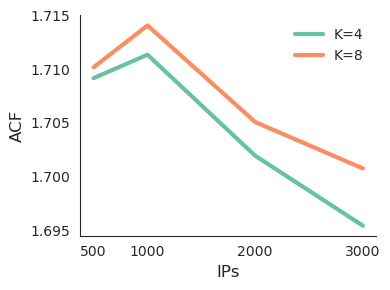

In [278]:
from matplotlib.lines import Line2D

#nnnsf_poi_k2 = pd.read_csv(path.join(SPATH, 'merfish_acf_k=2_rm.csv'), index_col=0)
nnnsf_poi_k4 = pd.read_csv(path.join(SPATH, 'merfish_acf_k=4_rm.csv'), index_col=0)
nnnsf_poi_k8 = pd.read_csv(path.join(SPATH, 'merfish_acf_k=8_rm.csv'), index_col=0)

nnnsf_df_k2 = nnnsf_poi_k2
nnnsf_df_k4 = nnnsf_poi_k4
nnnsf_df_k8 = nnnsf_poi_k8

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)

# Load Set2 palette colors
sns.set_style("white")
colors = sns.color_palette("Set2", n_colors=5)

# Plot each line with a color from the Set2 palette
#sns.lineplot(x=M, y=nnnsf_df_k2['6'], label='K=2', color=colors[0], linewidth=2, markersize=8)
sns.lineplot(x=M, y=nnnsf_df_k4['6'], label='K=4', color=colors[0], linewidth=3, markersize=8)
sns.lineplot(x=M, y=nnnsf_df_k8['6'], label='K=8', color=colors[1], linewidth=3, markersize=8)

# Customize x-ticks and labels
ax.set_xticks(M)
ax.set_xticklabels(M)
ax.set_xlabel("IPs", size=12)
ax.set_ylabel("ACF", size=12)

# Display legend without frame
plt.legend(frameon=False)

plt.tight_layout()
sns.despine()
plt.savefig(f'{SPATH}/merfish_nnnsf_acf_l=6.png', bbox_inches='tight')
plt.show()